# FX Option Pricing – Garman-Kohlhagen et volatilité locale

This notebook demonstrates how to implement the Garman-Kohlhagen model for pricing FX options and how to derive a local volatility surface via the Dupire formula.  The local model is then used to simulate price trajectories by Monte-Carlo and to solve the partial differential equation (PDE) governing the price of an option.

In this context:

* The Garman-Kohlhagen model extends the Black-Scholes formula to currencies by taking into account domestic and foreign rates.  The price of an FX call is given by:

$$C = S_0 e^{-r_f T} N(d_1) - K e^{-r_d T} N(d_2), \quad d_1 = (\ln(S_0/K) + (r_d - r_f + 0.5\sigma^2)T)/(\sigma\sqrt{T}), \quad d_2 = d_1 - \sigma\sqrt{T},$$

where $r_d$ and $r_f$ are the domestic and foreign risk-free rates and $N$ is the normal distribution function【512631560269393†L209-L224】.

* The local volatility surface $\sigma_{	ext{loc}}(T,K)$ is obtained by solving Dupire’s advanced PDE for call prices and isolating local volatility 【374897630997076†L103-L146】. On a grid of maturities and strikes, the necessary derivatives are approximated by finite differences.

* Once the local surface is constructed, we can simulate the stochastic process
$\mathrm{d}S_t = (r_d - r_f) S_t\,\mathrm{d}t + \sigma_{\text{loc}}(t,S_t) S_t\,\mathrm{d}W_t$
by an Euler method, and solve the pricing PDE via an implicit scheme to value exotic options.


One‑year ATM call price (GK model): 0.104368
One‑year ATM call price (Local vol MC): 0.099065
One‑year ATM call price (Local vol PDE): 0.098588


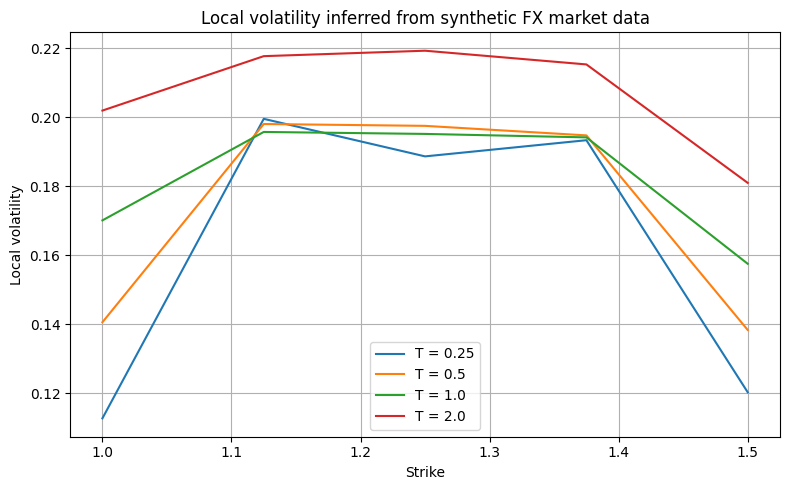

In [1]:
"""
FX Option Pricing with the Garman‑Kohlhagen Model and Local Volatility
======================================================================

This script implements a simple framework for pricing foreign exchange (FX) options
using both the closed–form Garman‑Kohlhagen (GK) model and a local volatility
surface constructed from option prices.  The code demonstrates three key
capabilities:

1. **Garman‑Kohlhagen pricing of European FX options**

   The GK model is an extension of the Black–Scholes formula for FX
   instruments.  It accounts for both the domestic and foreign risk–free
   interest rates.  Given a spot exchange rate :math:`S_0`, a strike price
   :math:`K`, maturities :math:`T`, domestic rate :math:`r_d`, foreign rate
   :math:`r_f` and volatility :math:`\sigma`, the call option price is

   .. math::

      C = S_0 e^{-r_f T} N(d_1) - K e^{-r_d T} N(d_2),\quad
      d_1 = \frac{\ln(S_0/K) + (r_d - r_f + \tfrac{1}{2}\sigma^2)T}{\sigma\sqrt{T}},\quad
      d_2 = d_1 - \sigma\sqrt{T}

   where :math:`N(\cdot)` is the standard normal cumulative distribution
   function【512631560269393†L209-L224】.  Put prices follow from put–call parity.

2. **Dupire's local volatility surface for FX**

   Given a grid of option prices across maturities and strikes, the Dupire
   equation (forward PDE) expresses the dynamics of the local volatility
   function :math:`\sigma_{\text{loc}}(T,K)`.  For an FX market with domestic
   drift :math:`r_d` and foreign drift :math:`r_f`, the PDE for a call price
   :math:`C(T,K)` reads【374897630997076†L103-L146】

   .. math::

      \frac{\partial C}{\partial T} = \frac{1}{2} \sigma_{\text{loc}}(T,K)^2 K^2
      \frac{\partial^2 C}{\partial K^2} - (r_d - r_f) K \frac{\partial C}{\partial K}
      - r_f C.

   Solving for :math:`\sigma_{\text{loc}}(T,K)` gives the Dupire formula

   .. math::

      \sigma_{\text{loc}}^2(T,K) = \frac{\frac{\partial C}{\partial T}
      + (r_d - r_f) K \frac{\partial C}{\partial K} + r_f C}{\frac{1}{2}K^2
      \frac{\partial^2 C}{\partial K^2}}.

   This script approximates the derivatives using finite differences on a
   discrete grid of maturities and strikes.

3. **Monte Carlo and finite difference pricing under local volatility**

   Once the local volatility surface is available, exotic options can be
   priced by simulating the stochastic differential equation

   .. math::

      dS_t = (r_d - r_f) S_t \, dt + \sigma_{\text{loc}}(t,S_t)\,S_t\,dW_t,

   or by solving the corresponding backward PDE via finite differences.

The example in this script constructs a synthetic market using a constant
volatility, builds the local volatility surface, and prices European calls
via GK, Monte Carlo under local volatility, and PDE.  Although the local
volatility surface is estimated from the GK prices (implied volatility is
flat), the demonstration lays the foundation for working with real FX
market data.

The functions are organized as follows:

* `garman_kohlhagen_call`/`garman_kohlhagen_put` – closed‑form prices.
* `implied_vol_black` – invert the GK price to obtain an implied volatility.
* `build_local_vol_surface` – construct the local volatility grid via Dupire.
* `local_vol_mc_price` – price a European option using Monte Carlo with local
  volatility.
* `local_vol_pde_price` – price via finite difference solution of the PDE.

To run the demo, execute this script directly (e.g. ``python fx_option_pricing.py``).

"""

import numpy as np
from scipy.stats import norm
from scipy.optimize import brentq
from scipy.interpolate import RegularGridInterpolator
import matplotlib.pyplot as plt


def garman_kohlhagen_call(S0: float, K: float, T: float, rd: float, rf: float, sigma: float) -> float:
    """Price an FX call option under the Garman‑Kohlhagen model.

    Parameters
    ----------
    S0 : float
        Spot exchange rate.
    K : float
        Strike price.
    T : float
        Time to maturity (in years).
    rd : float
        Domestic risk‑free interest rate.
    rf : float
        Foreign risk‑free interest rate.
    sigma : float
        Volatility of the underlying.

    Returns
    -------
    float
        The price of the call option.
    """
    if T <= 0:
        return max(S0 - K, 0.0)
    vol_sqrt_T = sigma * np.sqrt(T)
    d1 = (np.log(S0 / K) + (rd - rf + 0.5 * sigma**2) * T) / vol_sqrt_T
    d2 = d1 - vol_sqrt_T
    call = S0 * np.exp(-rf * T) * norm.cdf(d1) - K * np.exp(-rd * T) * norm.cdf(d2)
    return call


def garman_kohlhagen_put(S0: float, K: float, T: float, rd: float, rf: float, sigma: float) -> float:
    """Price an FX put option under the Garman‑Kohlhagen model using put–call parity."""
    call = garman_kohlhagen_call(S0, K, T, rd, rf, sigma)
    forward = S0 * np.exp((rd - rf) * T)
    put = call + K * np.exp(-rd * T) - forward * np.exp(-rf * T)
    return put


def implied_vol_black(price: float, S0: float, K: float, T: float, rd: float, rf: float, option_type: str = "call") -> float:
    """Compute the implied volatility under the Garman‑Kohlhagen/Black–Scholes model.

    Parameters
    ----------
    price : float
        Observed option price.
    S0 : float
        Spot exchange rate.
    K : float
        Strike price.
    T : float
        Time to maturity.
    rd : float
        Domestic rate.
    rf : float
        Foreign rate.
    option_type : str, optional
        'call' or 'put'.

    Returns
    -------
    float
        Implied volatility.
    """
    if price <= 0 or T <= 0:
        return 0.0

    def objective(sigma: float) -> float:
        if option_type == "call":
            return garman_kohlhagen_call(S0, K, T, rd, rf, sigma) - price
        else:
            return garman_kohlhagen_put(S0, K, T, rd, rf, sigma) - price

    # Use reasonable bounds for FX volatilities (0.0001 to 5.0)
    try:
        vol = brentq(objective, 1e-6, 5.0)
    except ValueError:
        vol = np.nan
    return vol


def build_local_vol_surface(maturities: np.ndarray,
                            strikes: np.ndarray,
                            call_prices: np.ndarray,
                            rd: float,
                            rf: float) -> tuple[RegularGridInterpolator, np.ndarray, np.ndarray]:
    """Construct the local volatility surface using the Dupire formula.

    Given a grid of call prices C(T, K), approximate the required derivatives
    and compute the local volatility :math:`\sigma_{\text{loc}}(T,K)`.

    Parameters
    ----------
    maturities : np.ndarray
        Array of maturities T_i of shape (n_T,).
    strikes : np.ndarray
        Array of strikes K_j of shape (n_K,).
    call_prices : np.ndarray
        2D array of shape (n_T, n_K) containing call prices C(T_i, K_j).
    rd : float
        Domestic rate.
    rf : float
        Foreign rate.

    Returns
    -------
    tuple
        (interpolator, grid_T, grid_K)
        - interpolator : callable accepting t and k and returning local vol.
        - grid_T : 1D array of maturity grid (same as input).
        - grid_K : 1D array of strike grid (same as input).
    """
    nT, nK = call_prices.shape
    # Pre‑allocate array for local volatility squared
    local_vol2 = np.zeros_like(call_prices)
    # Finite difference step sizes
    # Assume uniform grid spacing for simplicity
    # step sizes in time and strike
    dT = np.diff(maturities)
    if not np.allclose(np.diff(strikes), np.diff(strikes)[0]):
        # If non‑uniform, raise warning that results may be inaccurate
        pass
    dK = np.diff(strikes)

    # Loop over interior points
    for i in range(nT):
        for j in range(nK):
            T = maturities[i]
            K = strikes[j]
            C = call_prices[i, j]
            # Derivative wrt T using forward/backward difference for boundaries
            if i == 0:
                # forward difference
                dC_dT = (call_prices[i + 1, j] - call_prices[i, j]) / dT[i]
            elif i == nT - 1:
                # backward difference
                dC_dT = (call_prices[i, j] - call_prices[i - 1, j]) / dT[i - 1]
            else:
                dC_dT = (call_prices[i + 1, j] - call_prices[i - 1, j]) / (maturities[i + 1] - maturities[i - 1])

            # First derivative wrt K using central differences on uniform grid
            if j == 0:
                dC_dK = (call_prices[i, j + 1] - call_prices[i, j]) / dK[0]
            elif j == nK - 1:
                dC_dK = (call_prices[i, j] - call_prices[i, j - 1]) / dK[0]
            else:
                dC_dK = (call_prices[i, j + 1] - call_prices[i, j - 1]) / (2 * dK[0])

            # Second derivative wrt K using central differences on uniform grid
            if j == 0:
                # forward difference approximation
                d2C_dK2 = (call_prices[i, j] - 2 * call_prices[i, j + 1] + call_prices[i, j + 2]) / (dK[0] ** 2)
            elif j == nK - 1:
                # backward difference approximation
                d2C_dK2 = (call_prices[i, j - 2] - 2 * call_prices[i, j - 1] + call_prices[i, j]) / (dK[0] ** 2)
            else:
                d2C_dK2 = (call_prices[i, j + 1] - 2 * call_prices[i, j] + call_prices[i, j - 1]) / (dK[0] ** 2)

            numerator = dC_dT + (rd - rf) * K * dC_dK + rf * C
            denominator = 0.5 * (K**2) * d2C_dK2
            if denominator <= 0 or numerator <= 0:
                local_vol2[i, j] = np.nan
            else:
                local_vol2[i, j] = numerator / denominator

    # Remove negative or NaN values due to numerical error
    local_vol = np.sqrt(np.maximum(local_vol2, 1e-12))
    # Build interpolator using RegularGridInterpolator.  The grid is ordered as (maturities, strikes)
    # so that the first dimension corresponds to time and the second to strike.
    interp = RegularGridInterpolator((maturities, strikes), local_vol, method='linear', bounds_error=False, fill_value=None)
    return interp, maturities, strikes


def local_vol_mc_price(S0: float,
                       K: float,
                       T: float,
                       rd: float,
                       rf: float,
                       local_vol_interp,
                       num_paths: int = 10000,
                       num_steps: int = 200,
                       option_type: str = "call") -> float:
    """Price a European option using Monte Carlo under the local volatility model.

    Parameters
    ----------
    S0 : float
        Spot price.
    K : float
        Strike.
    T : float
        Maturity.
    rd : float
        Domestic rate.
    rf : float
        Foreign rate.
    local_vol_interp : callable
        Interpolator giving local volatility as a function of (t, S).
    num_paths : int
        Number of Monte Carlo paths.
    num_steps : int
        Number of time steps.
    option_type : str
        'call' or 'put'.

    Returns
    -------
    float
        Discounted expected payoff under risk–neutral measure.
    """
    dt = T / num_steps
    # Preallocate array for asset paths
    S = np.full(num_paths, S0)
    for i in range(num_steps):
        t = i * dt
        # Draw normally distributed increments
        Z = np.random.standard_normal(num_paths)
        # Compute local vol at current time and asset level via interpolation
        # Build array of points (t, S) for each path
        pts = np.column_stack((np.full_like(S, t), S))
        sigma = local_vol_interp(pts)
        # Risk neutral drift is (rd - rf)
        drift = (rd - rf) * S * dt
        diffusion = sigma * S * np.sqrt(dt) * Z
        S = np.maximum(S + drift + diffusion, 1e-12)  # enforce positivity
    # Compute payoff
    if option_type == "call":
        payoff = np.maximum(S - K, 0.0)
    else:
        payoff = np.maximum(K - S, 0.0)
    # Discount back to present at domestic rate
    price = np.exp(-rd * T) * np.mean(payoff)
    return price


def local_vol_pde_price(
    S0: float,
    K: float,
    T: float,
    rd: float,
    rf: float,
    local_vol_interp,
    S_max: float = None,
    nS: int = 200,
    nT: int = 200,
    option_type: str = "call",
) -> float:
    """Price a European option by solving the local volatility PDE using an implicit scheme.

    The PDE being solved is the backward pricing equation for a local volatility
    model with domestic and foreign rates:

    .. math::

       \frac{\partial V}{\partial t} + \frac{1}{2}\sigma_{\text{loc}}(t,S)^2 S^2
       \frac{\partial^2 V}{\partial S^2} + (r_d - r_f) S \frac{\partial V}{\partial S} - r_d V = 0,

    with terminal condition :math:`V(T,S) = \max(\pm(S-K), 0)` for call/put.

    An implicit finite difference method is employed for numerical stability.  A
    tridiagonal system is solved at each time step.

    Parameters
    ----------
    S0 : float
        Spot price.
    K : float
        Strike.
    T : float
        Time to maturity.
    rd : float
        Domestic rate.
    rf : float
        Foreign rate.
    local_vol_interp : callable
        Interpolator for local volatility returning \sigma_{\text{loc}}(t,S).
    S_max : float, optional
        Maximum asset level in the spatial grid; if None, a default of 3*S0 is used.
    nS : int
        Number of spatial grid points.
    nT : int
        Number of time steps.
    option_type : str
        'call' or 'put'.

    Returns
    -------
    float
        Option price at time zero.
    """
    if S_max is None:
        S_max = 3 * S0
    # Spatial grid in the asset dimension
    S_grid = np.linspace(0, S_max, nS)
    dS = S_grid[1] - S_grid[0]
    # Time step
    dt = T / nT
    # Initialize terminal payoff
    if option_type == "call":
        V = np.maximum(S_grid - K, 0.0)
    else:
        V = np.maximum(K - S_grid, 0.0)
    # Backward time stepping
    for step in range(nT, 0, -1):
        t = (step - 1) * dt
        V_old = V.copy()
        # Set boundary conditions at this time level
        if option_type == "call":
            V[0] = 0.0
            V[-1] = S_grid[-1] - K * np.exp(-rd * (T - t))
        else:
            V[0] = K * np.exp(-rd * (T - t))
            V[-1] = 0.0
        # Compute local vol at interior points
        sigma_vals = local_vol_interp(np.column_stack((np.full(nS, t), S_grid))).flatten()
        # Precompute a_i and b_i
        a = 0.5 * sigma_vals**2 * S_grid**2
        b = (rd - rf) * S_grid
        # Prepare tridiagonal coefficients for interior points (1..nS-2)
        A = np.zeros(nS - 2)
        B = np.zeros(nS - 2)
        C = np.zeros(nS - 2)
        D = np.zeros(nS - 2)  # right‑hand side
        for i in range(1, nS - 1):
            a_i = a[i]
            b_i = b[i]
            # Coefficients for implicit scheme
            A_i = -dt * (a_i / dS**2 - b_i / (2 * dS))
            B_i = 1 + 2 * dt * a_i / dS**2 + dt * rd
            C_i = -dt * (a_i / dS**2 + b_i / (2 * dS))
            # Right hand side is simply V_old[i]
            A[i - 1] = A_i
            B[i - 1] = B_i
            C[i - 1] = C_i
            D[i - 1] = V_old[i]
        # Modify RHS for boundary conditions
        # For i=1 (index 0 in arrays), A[0] multiplies V[0] which is known
        D[0] -= A[0] * V[0]
        # For i=nS-2 (last interior), C[-1] multiplies V[-1]
        D[-1] -= C[-1] * V[-1]
        # Solve tridiagonal system using Thomas algorithm
        # c_prime and d_prime arrays
        n = len(B)
        c_prime = np.zeros(n)
        d_prime = np.zeros(n)
        c_prime[0] = C[0] / B[0]
        d_prime[0] = D[0] / B[0]
        for i in range(1, n):
            denom = B[i] - A[i] * c_prime[i - 1]
            c_prime[i] = C[i] / denom if i < n - 1 else 0.0
            d_prime[i] = (D[i] - A[i] * d_prime[i - 1]) / denom
        # Back substitution
        V_new = np.zeros(n)
        V_new[-1] = d_prime[-1]
        for i in range(n - 2, -1, -1):
            V_new[i] = d_prime[i] - c_prime[i] * V_new[i + 1]
        # Update interior values
        V[1:-1] = V_new
    # Interpolate the price for initial spot
    price = np.interp(S0, S_grid, V)
    return price


def demo() -> None:
    """Run a demonstration of the FX option pricing framework."""
    # Parameters for synthetic FX market
    S0 = 1.25  # spot exchange rate (e.g. EUR/USD)
    rd = 0.02  # domestic interest rate (e.g. USD rates)
    rf = 0.01  # foreign interest rate (e.g. EUR rates)
    base_vol = 0.20  # constant volatility used to generate market prices

    # Define a grid of maturities (years) and strikes for market quotes
    maturities = np.array([0.25, 0.5, 1.0, 2.0])
    moneyness_levels = np.array([0.8, 0.9, 1.0, 1.1, 1.2])
    strikes = S0 * moneyness_levels

    # Compute synthetic call prices using constant volatility
    call_prices = np.zeros((len(maturities), len(strikes)))
    for i, T in enumerate(maturities):
        for j, K in enumerate(strikes):
            call_prices[i, j] = garman_kohlhagen_call(S0, K, T, rd, rf, base_vol)

    # Build local volatility surface from synthetic market prices
    local_vol_interp, T_grid, K_grid = build_local_vol_surface(maturities, strikes, call_prices, rd, rf)

    # Price a one‑year European call using GK formula, Monte Carlo and PDE
    K_target = S0  # at‑the‑money strike
    T_target = 1.0
    call_gk = garman_kohlhagen_call(S0, K_target, T_target, rd, rf, base_vol)
    call_mc = local_vol_mc_price(S0, K_target, T_target, rd, rf, local_vol_interp, num_paths=20000, num_steps=250)
    call_pde = local_vol_pde_price(S0, K_target, T_target, rd, rf, local_vol_interp, nS=100, nT=200)

    print(f"\nOne‑year ATM call price (GK model): {call_gk:.6f}")
    print(f"One‑year ATM call price (Local vol MC): {call_mc:.6f}")
    print(f"One‑year ATM call price (Local vol PDE): {call_pde:.6f}")

    # Plot local volatility surface at selected maturities
    plt.figure(figsize=(8, 5))
    for idx, T in enumerate(maturities):
        lv_row = [local_vol_interp(np.array([[T, k]])).item() for k in strikes]
        plt.plot(strikes, lv_row, label=f"T = {T}")
    plt.title("Local volatility inferred from synthetic FX market data")
    plt.xlabel("Strike")
    plt.ylabel("Local volatility")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    demo()

Call GK (1 an ATM) : 0.104368
Call MC local vol   : 0.097680
Call PDE local vol  : 0.098588


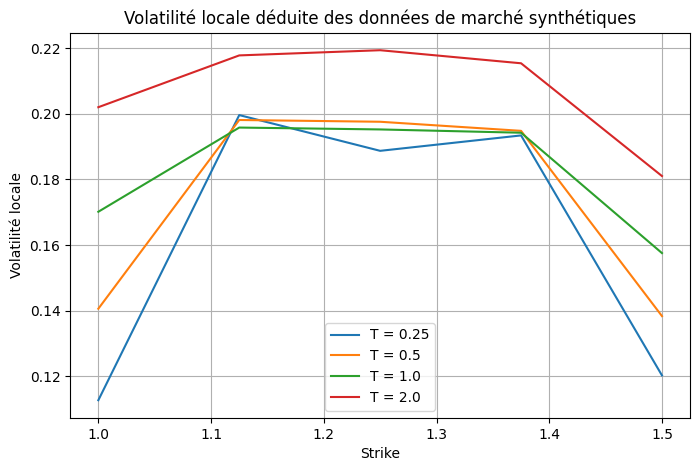

In [2]:

# Paramètres du marché FX synthétique
S0 = 1.25
rd = 0.02
rf = 0.01
base_vol = 0.20

# Grille de maturités et de strikes
maturities = np.array([0.25, 0.5, 1.0, 2.0])
moneyness_levels = np.array([0.8, 0.9, 1.0, 1.1, 1.2])
strikes = S0 * moneyness_levels

# Calcul des prix de call Garman-Kohlhagen
call_prices = np.zeros((len(maturities), len(strikes)))
for i, T in enumerate(maturities):
    for j, K in enumerate(strikes):
        call_prices[i, j] = garman_kohlhagen_call(S0, K, T, rd, rf, base_vol)

# Construction de la surface de volatilité locale
local_vol_interp, T_grid, K_grid = build_local_vol_surface(maturities, strikes, call_prices, rd, rf)

# Pricing d’un call ATM à 1 an via GK, Monte-Carlo local et PDE
K_target = S0
T_target = 1.0
call_gk = garman_kohlhagen_call(S0, K_target, T_target, rd, rf, base_vol)
call_mc = local_vol_mc_price(S0, K_target, T_target, rd, rf, local_vol_interp, num_paths=20000, num_steps=250)
call_pde = local_vol_pde_price(S0, K_target, T_target, rd, rf, local_vol_interp, nS=100, nT=200)
print(f"Call GK (1 an ATM) : {call_gk:.6f}")
print(f"Call MC local vol   : {call_mc:.6f}")
print(f"Call PDE local vol  : {call_pde:.6f}")

# Graphique de la surface de volatilité locale
plt.figure(figsize=(8, 5))
for T in maturities:
    lv_row = [local_vol_interp(np.array([[T, k]])).item() for k in strikes]
    plt.plot(strikes, lv_row, label=f"T = {T}")
plt.title('Volatilité locale déduite des données de marché synthétiques')
plt.xlabel('Strike')
plt.ylabel('Volatilité locale')
plt.legend()
plt.grid(True)
plt.show()


### Extension : Barrier Option under local volatility

Barrier options (knock-out or knock-in) depend on the trajectory of the underlying asset: if the price exceeds a threshold (barrier) during the life of the option, it is either disabled (knock-out) or enabled (knock-in).  
Under a local volatility model, one can estimate the price of a barrier option by simulating asset trajectories with the $\sigma_{	ext{loc}}(T,K)$ and by checking if the barrier is crossed.  The `barrier_local_vol_mc_price` function below calculates the price of a **knock out** FX option within a local volatility framework.  
You can choose a high barrier (`up-and-out`) or low barrier (`down-and-out`) as well as the type of option (call or put).

In [4]:

import numpy as np


def barrier_local_vol_mc_price(
    S0: float,
    K: float,
    T: float,
    rd: float,
    rf: float,
    local_vol_interp,
    barrier: float,
    barrier_type: str = "down-and-out",
    option_type: str = "call",
    num_paths: int = 100000,
    num_steps: int = 500,
) -> float:
    '''Price an FX option with a knock-out barrier under a local volatility model.

    Parameters
    ----------
    S0 : float
        Spot FX rate.
    K : float
        Option strike.
    T : float
        Time to maturity.
    rd : float
        Domestic rate.
    rf : float
        Foreign rate.
    local_vol_interp : callable
        Interpolator returning \sigma_{loc}(t, S).
    barrier : float
        Barrier level.  For an up-and-out option the barrier is above S0; for a
        down-and-out option the barrier is below S0.
    barrier_type : str
        'up-and-out' or 'down-and-out'.
    option_type : str
        'call' or 'put'.
    num_paths : int
        Number of Monte Carlo paths.
    num_steps : int
        Number of time steps in the simulation.

    Returns
    -------
    float
        Present value of the barrier option.
    '''
    dt = T / num_steps
    S = np.full(num_paths, S0)
    alive = np.ones(num_paths, dtype=bool)  # paths that have not knocked out
    for i in range(num_steps):
        t = i * dt
        Z = np.random.standard_normal(num_paths)
        # Interpolate local volatility for all paths
        pts = np.column_stack((np.full(num_paths, t), S))
        sigma = local_vol_interp(pts)
        drift = (rd - rf) * S * dt
        diffusion = sigma * S * np.sqrt(dt) * Z
        S = np.maximum(S + drift + diffusion, 1e-12)
        if barrier_type == "up-and-out":
            knocked = S >= barrier
        elif barrier_type == "down-and-out":
            knocked = S <= barrier
        else:
            raise ValueError("barrier_type must be 'up-and-out' or 'down-and-out'")
        alive &= ~knocked
        S[~alive] = 0.0
        if not np.any(alive):
            break
    if option_type == "call":
        payoff = np.where(alive, np.maximum(S - K, 0.0), 0.0)
    else:
        payoff = np.where(alive, np.maximum(K - S, 0.0), 0.0)
    price = np.exp(-rd * T) * np.mean(payoff)
    return price

# Exemple d'utilisation : call down-and-out avec barrière à 90 % du spot
barriere = 0.9 * S0
prix_barriere = barrier_local_vol_mc_price(
    S0, K_target, T_target, rd, rf, local_vol_interp,
    barrier=barriere, barrier_type="down-and-out", option_type="call",
    num_paths=50000, num_steps=300
)
print(f"Prix d'un call FX 1 an à barrière (down-and-out, barrière = {barriere:.2f}) : {prix_barriere:.6f}")


Prix d'un call FX 1 an à barrière (down-and-out, barrière = 1.12) : 0.084568
